# DVL Navigation and State Estimation

1. [Import Libraries](#import-libraries)
1. [Load and Parse Data](#load-and-parse-data)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [DVL Data](#import-dvl-data)
    1. [Bathymetry Data](#import-bathymetry)
    1. [Select Time Series](#import-select-time-series)
    1. [Time Synchronization Fix](#import-time-synchronization-fix)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Based Navigation](#multi-factor-terrain-based-navigation)
    1. [Plot Navigation Results](#plot-navigation-results)
    1. [Navigation Performance](#navigation-performance)
        2. [Print Performance metrics](#print_metrics)
1. [Sandbox](#sandbox)


---
<a id='import-libraries'></a>
## Import Libraries

In [674]:
import datetime
#import earthpy as et
#import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join
from scipy.spatial.transform import Rotation as R
from scipy import interpolate

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap
import MultiFactorTAN

# data for parsing seafloor bathymetry
import bathy_meta_data
sns.set()

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)
    importlib.reload(MultiFactorTAN)
print('Done!')

Done!


---
<a id='load-and-parse-data'></a>
## Load and/or Parse Data
<a id='import-glider-flight-computer'></a>
### A. Glider Flight Computer Data

In [675]:
reload_modules()
directory = "C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/dbd-parsed/sentinel_2019-Nov/"
ts_flight_kolumbo_all = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)

>> Parsing folder of ASC Files
>> Finished Parsing!


---
<a id='import-dvl-data'></a>
### B. DVL data 

In [ ]:
glider = "sentinel"
filepath = "C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/pd0-raw/%s/" % (glider)

#################################################
# File ID Number ################################
#################################################
filename2  = "sk211652.pd0" # DIVE 2
filename3  = "01820002.pd0" # DIVE 3
filename4  = "sk220034.pd0" # DIVE 4
filename5  = "01820008.pd0" # DIVE 5
filename7  = "01820013.pd0" # DIVE 7
filename9  = "sk222256.pd0" # DIVE 9
filename12 = "sk230350.pd0" # DIVE 12
filename14 = "sk261222.pd0" # DIVE 14

#################################################
# Parse Selected File IDs #######################
#################################################
# ts2  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename2,  save=False)
ts3  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename3,  save=False)
ts4  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename4,  save=False)
ts5  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename5,  save=False)
ts7  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename7,  save=False)
ts9  = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename9,  save=False)
# ts12 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename12, save=False)
ts14 = PathfinderTimeSeries.PathfinderTimeSeries.from_pd0(filepath+filename14, save=False)

#################################################
# Frontiers (and Thesis) Naming Convention ###################
#################################################
# tsb  = ts12 # (no bottom)
# tsc  = ts2 # (no bottom)
# tsh  = ts9 # (not included in Frontiers) (also doesn't look like too much bottom?)
# tsd  = ts3 #(crazy dive)
tsa  = ts14
tse  = ts4
tsf  = ts5
tsg  = ts7 # (not included in Frontiers)



#################################################
# JFR Naming Convention #########################
#################################################
# tsa  = ts14
# tsb  = ts5
# tsc  = ts4 
# tsd  = ts3
# tse = ts7

---
<a id='import-bathymetry'></a>
### C. Seafloor Bathymetry Data

In [757]:
reload_modules()
# meta_dict = bathy_meta_data.BathyData["Kolumbo_full"]
# meta_dict = bathy_meta_data.BathyData["Kolumbo"]
# bathy     = BathymetryMap.BathymetryMap(meta_dict=meta_dict)
# bathy.parse_bathy_file()


# bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-utm-sub.csv')
# bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-withVar.csv')

# bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-low-res-test.csv')
# bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-low-res-test-var.csv')

#Test 04 with orientation normalzied to 0 -360 deg
bathy_df = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-test04.csv')
bathy_df_var = pd.read_csv('C:/Users/grego/Dropbox/Kolumbo cruise 2019/zduguid/bathy/Kolumbo-10m-sub-test04-var.csv')
print('Finished loading bathymetry data')

Finished loading bathymetry data


<a id='import-select-time-series'></a>
### D. Select Time Series 

In [842]:
#Select Time Series to Run Naviagation Code on
#ts_label is purely for visual results at end (not important for code)
ts = tsa
ts_label = 'A'


<a id='import-time-synchronization-fix'></a>
### E. Time Synchronization Fix

In [843]:
#extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

RAD_TO_DEG = 180/np.pi
new_pitch_list = [] 
new_roll_list = []
new_heading_list = []

for t in range(len(ts.df)):
    # extract timestamp from PD0 file and corresponding sections of DBD file
    time   = ts.df.time[t]
    target = datetime.datetime.fromtimestamp(time)
    lower  = df_dbd[:str(target)]
    upper  = df_dbd[str(target):]
    
    # handle edge cases when interpolation is not possible  
    if len(lower)==0:
        new_pitch_list.append(upper.m_pitch[0]*RAD_TO_DEG)
        new_roll_list.append(upper.m_roll[0]*RAD_TO_DEG)
        new_heading_list.append(upper.m_heading[0]*RAD_TO_DEG)
        continue
    if len(upper)==0:
        new_pitch_list.append(lower.m_pitch[-1]*RAD_TO_DEG)
        new_roll_list.append(lower.m_roll[-1]*RAD_TO_DEG)
        new_heading_list.append(lower.m_heading[-1]*RAD_TO_DEG)
        continue 

    lower_time  = lower.time[-1]
    lower_pitch = lower.m_pitch[-1]
    lower_roll  = lower.m_roll[-1]
    lower_heading   = lower.m_heading[-1]
    upper_time  = upper.time[0]
    upper_pitch = upper.m_pitch[0]
    upper_roll  = upper.m_roll[0]
    upper_heading   = upper.m_heading[0]
    delta_t     = upper_time-lower_time
    
    # case when DBD data is repeated in successive timestamps
    if delta_t == 0:
        new_pitch_list.append(lower.m_pitch[-1]*RAD_TO_DEG)
        new_roll_list.append(lower.m_roll[-1]*RAD_TO_DEG)
        new_heading_list.append(lower.m_heading[-1]*RAD_TO_DEG)
        continue
        
    # take linear interpolation between DBD values
    lower_per   = (time-lower_time)/delta_t
    upper_per   = 1 - lower_per
    new_pitch   = lower_pitch*lower_per + upper_pitch*upper_per
    new_pitch_list.append(new_pitch*RAD_TO_DEG)
    new_roll   = lower_roll*lower_per + upper_roll*upper_per
    new_roll_list.append(new_roll*RAD_TO_DEG)
    new_heading   = lower_heading*lower_per + upper_heading*upper_per
    new_heading_list.append(new_heading*RAD_TO_DEG)
    
ts.df['pitch'] = new_pitch_list
ts.df['roll']  = new_roll_list
ts.df['heading']   = new_heading_list
print('> New pitch, roll, and heading data extracted!')

> New pitch, roll, and heading data extracted!


---
<a id='compute-water-column-currents'></a>
## Compute Water Column Currents 

In [844]:
reload_modules()

# tuning parameters for working with DVL data 
pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  2    # [bin #] avoid using the first number of bins
end_filter           =  2    # [bin #] avoid using the last number of bins 
voc_mag_filter       =  1.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5  # [m/s]   filter out deltas between layers
near_surface_filter  = 10    # [m]     ignore Vtw when near surface 

# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 80
max_depth    = int(np.max(ts.df.depth)+80)
x_beam       = 0
y_beam       = 1

# intialize water column
water_column = VelocityShearPropagation.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    pitch = ts.df.pitch[t]
    roll  = ts.df.roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # extract Voc reference from bottom track velocity when available
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = VelocityShearPropagation.OceanCurrent(voc_u, voc_v, 0)
    else:
        voc_ref = VelocityShearPropagation.OceanCurrent()
        
    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t]
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (-dvl_x))
            delta_voc_v.append(vtw_v - (-dvl_y))

        shear_list = [VelocityShearPropagation.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )
        
voc_u_list,voc_v_list,voc_w_list,voc_z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
#print(water_column.averages_to_str())
#dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, voc_z_list, save_name='tmp-water-column.png')

> Finished Estimating Water Column Currents!


---
<a id='compute-dvl-odometry'></a>
## Compute DVL-Odometry

In [845]:
# How long (in mins) will algorithm accept ocean current estimates i.e. forgetting factor
ocean_current_time_filter = 15 # mins
    
# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]
delta_x_list = [0]
delta_y_list = [0]

vel_list_x = []
vel_list_y = []
u_list     = []
v_list     = []
# set flag for setting GPS updates
flag_gps_fix_at_surface = False 

# extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x = df_dbd.m_x_lmc[t]
        dbd_origin_y = df_dbd.m_y_lmc[t]
        break

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.time[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    
    #################################################################
    # retrieve ocean current estimate from water column 
    #voc_u = voc_u_list[int(depth)]
    #voc_v = voc_v_list[int(depth)]
    good_node_list = []
    count = 0
    cum_voc_u = 0
    cum_voc_v = 0
    # Extract all shear nodes at current depth
    wc_depth = water_column.get_wc_bin(depth)
    node_list = water_column.get_voc_at_depth(wc_depth)
    
    #Iterate through shear nodes at depth
    for shear_node in node_list:
        voc = shear_node.voc
        if not(voc.is_none()):
            # filter out large values when computing averages
            if voc.mag < voc_mag_filter:
                good_node_list.append(shear_node)
    ## TODO possibly --> Median filter of nodes at given depth         
#     if (len(good_node_list) > 0):
#         for i in range(len(good_node_list)):
#             if i == 0:
#                 count += 1
#                 cum_voc_u += good_node_list[0].voc.u
#                 cum_voc_v += good_node_list[0].voc.v
#             else: 
#                 time_between_current_estimates = good_node_list[i].t - good_node_list[0].t
#                 if time_between_current_estimates > (ocean_current_time_filter*60):
#                     count += 1 
#                     cum_voc_u += good_node_list[i].voc.u
#                     cum_voc_v += good_node_list[i].voc.v
#         #voc_avg = OceanCurrent(cum_voc_u/count, cum_voc_v/count, 0)
#         voc_u = cum_voc_u/count
#         voc_v = cum_voc_v/count
#         u_list.append(voc_u)
#         v_list.append(voc_v)

########################################################################
    MIN_NUM_NODES = 7
###TESTING More elastic filter with minimum amount of current estimates
    if (len(good_node_list) > 0):
            for i in range(len(good_node_list)):
                if i == 0:
                    count += 1
                    cum_voc_u += good_node_list[0].voc.u
                    cum_voc_v += good_node_list[0].voc.v
                elif (i <= MIN_NUM_NODES):
                    count += 1
                    cum_voc_u += good_node_list[i].voc.u
                    cum_voc_v += good_node_list[i].voc.v
                else: 
                    time_between_current_estimates = good_node_list[i].t - good_node_list[0].t
                    if time_between_current_estimates > (ocean_current_time_filter*60):
                        count += 1 
                        cum_voc_u += good_node_list[i].voc.u
                        cum_voc_v += good_node_list[i].voc.v
            #voc_avg = OceanCurrent(cum_voc_u/count, cum_voc_v/count, 0)
            voc_u = cum_voc_u/count
            voc_v = cum_voc_v/count
            u_list.append(voc_u)
            v_list.append(voc_v)
####################################################################                
    else:
        voc_u = np.nan
        voc_v = np.nan
        u_list.append(voc_u)
        v_list.append(voc_v)
    
    #################################################################
    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        vel_list_x.append(vog_u)
        vel_list_y.append(vog_v)
        
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t
            vel_list_x.append(vtw_u + voc_u)
            vel_list_y.append(vtw_v + voc_v)
    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t
            vel_list_x.append(vtw_u)
            vel_list_y.append(vtw_v)
    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t
            vel_list_x.append(voc_u)
            vel_list_y.append(voc_v)

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
                
                vel_list_x.append(cur_dbd.m_vx_lmc[0])
                vel_list_y.append(cur_dbd.m_vy_lmc[0])
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)
    delta_x_list.append(delta_x)
    delta_y_list.append(delta_y)

# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z
ts.df['delta_x']   = delta_x_list
ts.df['delta_y']   = delta_y_list

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


---
<a id='multi-factor-terrain-based-navigation'></a>
## Multi-Factor Terrain Based Navigation (MF-TAN)

In [846]:
reload_modules()

def get_utm_coords_from_glider_lat_lon(m_lat, m_lon):
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = m_lon % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon - lon_min)/MIN_OFFSET + lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    zone_letter  = utm_pos[3]
    return(easting, northing, zone, zone_letter)

# constants
JANUS_ANGLE = 30
DEG_TO_RAD  = np.pi/180
RAD_TO_DEG  = 1/DEG_TO_RAD
sin_janus   = np.sin(JANUS_ANGLE*DEG_TO_RAD)
cos_janus   = np.cos(JANUS_ANGLE*DEG_TO_RAD)
min_valid_slant_ranges = 3 

# AUG parameters
BIAS_PITCH   = 12.5  # [deg]
BIAS_ROLL    =  0.0  # [deg]
BIAS_HEADING =  0.0  # [deg]


# # TAN parameters
############################
# Long Dive (Dive A) ########
# DVL_ODO_DRIFT = 0.15 #Heuristic that determines growth of uncertaintyh based on worst-case DVL-ODO performance history
DVL_ODO_DRIFT = 0.20
TAN_RED_DRIFT = 0.70 #Every time there is a a valid MF-TAN fix, reduces r (positional uncertainty) by 30%
# TAU_DEPTH     = 2
# TAU_SLOPE     = 2
# TAU_ORIENT    = 4
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4
TAU_DEPTH     = 5
TAU_SLOPE     = 15
TAU_ORIENT    = 10
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4
TAN_WEIGHT    = 0.8

# ###########################
# # Short Dive (Dive F) #######
# DVL_ODO_DRIFT = 0.20
# TAN_RED_DRIFT = 0.90
# TAU_DEPTH     = 1
# TAU_SLOPE     = 20
# TAU_ORIENT    = 30
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4

#############################
# TEMPORARY #################
# DVL_ODO_DRIFT = 0.20
# TAN_RED_DRIFT = 0.90
# TAU_DEPTH     = 1
# TAU_SLOPE     = 0
# TAU_ORIENT    = 0
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4

################# TEMPORARY --> NEED to UNDERSTAND FULL EFFECT
# factor_depth_point  = 288.39 
# factor_slope_point  = 30.08
# factor_orient_point = 129.23


# heading offsets for the four DVL beams
beam_heading_offsets = {
    0 : -90, # 0 = Port
    1 :  90, # 1 = Starboard
    2 :   0, # 2 = Forward
    3 : 180, # 3 = Aft
}

            
# intialize point cloud object 
pc = MultiFactorTAN.PointCloud()
pc_bathy_depth  = [np.nan]
pc_bathy_slope  = [np.nan]
pc_bathy_orient = [np.nan]
MFTAN_depth  = np.array(bathy_df.depth_list)
MFTAN_slope  = np.array(bathy_df.slope_list)
MFTAN_orient = np.array(bathy_df.orient_list)


# initialize list to keep track of TAN information
tan_pos_x = [0]
tan_pos_y = [0]
tan_pos_z = [0]
tan_pos_r = [0]
dvl_pos_r = [0]
sf_tan_pos_x = [0]
sf_tan_pos_y = [0]
tan_update_x = []
tan_update_y = []
tan_update_t = []
tan_update_index  = [] 
tan_update_depth  = []
tan_update_slope  = []
tan_update_orient = []


# extract the relevant portion of the glider flight computer
start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
dur     = end_t - start_t 
df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
        dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
        dbd_origin_m_lat = df_dbd.m_lat[t]
        dbd_origin_m_lon = df_dbd.m_lon[t]
        break

dbd_utm_x, dbd_utm_y, _, zone_letter = get_utm_coords_from_glider_lat_lon(
    dbd_origin_m_lat, 
    dbd_origin_m_lon
)

##Adaptive TAU Testing Logs##
depth_var_list  = []
slope_var_list  = []
orient_var_list = []
utm_est_x_list  = []
utm_est_y_list  = []
#############################

# iterate over length of Dive 
for t in range(1,len(ts.df)):
        
    # retrieve previous position information
    time    = ts.df.time[t]
    prev_x  = tan_pos_x[-1]
    prev_y  = tan_pos_y[-1]
    prev_r  = tan_pos_r[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]
    delta_x = ts.df.delta_x[t]
    delta_y = ts.df.delta_y[t]
    delta_r = np.linalg.norm([delta_x, delta_y])
    sf_prev_x  = sf_tan_pos_x[-1]
    sf_prev_y  = sf_tan_pos_y[-1]
    
    # retrieve DVL odometry update for case when TAN fix not available
    dvl_odo_x = prev_x + delta_x
    dvl_odo_y = prev_y + delta_y
    sf_dvl_odo_x = sf_prev_x + delta_x
    sf_dvl_odo_y = sf_prev_y + delta_y
    dvl_odo_r = prev_r + delta_r*DVL_ODO_DRIFT
    dvl_pos_r.append(dvl_pos_r[-1]+delta_r*DVL_ODO_DRIFT)
    
    # extract slant ranges 
    slant_ranges = {
        0 : ts.df.btm_beam0_range[t] / cos_janus, # 0 = Port 
        1 : ts.df.btm_beam1_range[t] / cos_janus, # 1 = Starboard
        2 : ts.df.btm_beam2_range[t] / cos_janus, # 2 = Forward  
        3 : ts.df.btm_beam3_range[t] / cos_janus, # 3 = Aft 
    }

    # ignore case when less than three ranges are available
    valid_slant_ranges = {key:slant_ranges[key] for key in 
        slant_ranges.keys() if not np.isnan(slant_ranges[key])}
        
    # extract current AUV position in LMC coordinates
    aug_x = ts.df.rel_pos_x[t]
    aug_y = ts.df.rel_pos_y[t]
    aug_z = ts.df.rel_pos_z[t]
    aug_heading = ts.df.heading[t]
    aug_pitch   = ts.df.pitch[t]
    aug_roll    = ts.df.roll[t]
    
    # override current position if GPS fix is given 
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_x_lmc) != 0):
            if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
                gps_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x
                gps_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y
                flag_gps_fix_at_surface = True
                pc_bathy_depth.append(np.nan)
                pc_bathy_slope.append(np.nan)
                pc_bathy_orient.append(np.nan)
                tan_pos_x.append(gps_x)
                tan_pos_y.append(gps_y)
                tan_pos_z.append(depth)
                sf_tan_pos_x.append(gps_x)
                sf_tan_pos_y.append(gps_y)
                new_r = np.min([prev_r*0.5, 50])
                tan_pos_r.append(prev_r)
                continue
    
    # ignore case when 3 or less slant ranges are present
    # ignore case when glider is not sufficiently pitched
    #######################################Pose Filter##################### REMOVED
    if (len(valid_slant_ranges) < min_valid_slant_ranges): #or (abs(aug_pitch) < pc.MIN_PITCH)):
        pc_bathy_depth.append(np.nan)
        pc_bathy_slope.append(np.nan)
        pc_bathy_orient.append(np.nan)
        tan_pos_x.append(dvl_odo_x)
        tan_pos_y.append(dvl_odo_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(dvl_odo_r)
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
        continue
    
    # compute rotation matrices to go from instrument coords to earth coords
    aug_Qx = pc.Qx((aug_pitch   + BIAS_PITCH)   * DEG_TO_RAD)
    aug_Qy = pc.Qy((aug_roll    + BIAS_ROLL)    * DEG_TO_RAD)
    aug_Qz = pc.Qz((aug_heading + BIAS_HEADING) * DEG_TO_RAD)

    # extract bottom contact positions in Earth coordinate frame
    point_cloud = []
    for beam in valid_slant_ranges:
        r = valid_slant_ranges[beam]
        z = r*cos_janus  # vertical component 
        h = r*sin_janus  # horizontal component
        
        # get bottom contact in instrument coordinates
        beam_heading = beam_heading_offsets[beam]
        x  = h*np.sin(beam_heading*DEG_TO_RAD)
        y  = h*np.cos(beam_heading*DEG_TO_RAD)
        z *= -1  # z is positive upwards for rotation
        
        # rotate into Ship coordinates
        # + ship coordinates is a horizontal translation away from Earth coordinates
        inst_pos = np.array([[x], [y], [z]])
        ship_pos = np.dot(aug_Qz, np.dot(aug_Qy, np.dot(aug_Qx, inst_pos)))
        x,y,z    = tuple(ship_pos.flatten())
        z       *= -1  # z is positive downwards again
        
        # add to the point cloud
        # + keep track of ship coordinates for debugging purposes
        bt_point = MultiFactorTAN.BottomTrackPoint(t, beam, x, y, z, aug_x, aug_y, aug_z)
        pc.add_point(bt_point)
    
    # get the three bathymetry factors from the point cloud
    bathy_depth, bathy_slope, bathy_orient = pc.get_factors()
    pc_bathy_depth.append(bathy_depth)
    pc_bathy_slope.append(bathy_slope)
    pc_bathy_orient.append(bathy_orient)
    
    # update use DVL-Odometry update when no features are available
    # + navigation uncertainty r grows as a function of distance traveled
    if np.isnan(bathy_depth):
        tan_pos_x.append(dvl_odo_x)
        tan_pos_y.append(dvl_odo_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(dvl_odo_r)
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
        continue
    
    ###########################################
    #       Adaptive Tau Process *TESTING*    #
    ###########################################
    def find_nearest(array1, value1, array2, value2):
        array1 = np.asarray(array1)
        array2 = np.asarray(array2)
        idx = (np.abs(array1 - value1) + np.abs(array2-value2)).argmin()
        return idx
    
    def findVar_fromMap(x, y, df):
        
        idx = find_nearest(df.utm_x_list, x, df.utm_y_list, y)
        
        depth_var  = df.depth_var[idx]
        slope_var  = df.slope_var[idx]
        orient_var = df.orient_var[idx]
        return depth_var, slope_var, orient_var
    
    def generateTAU(depth_var, slope_var, orient_var):
        # How do we model adding the noise/uncertainty/error that comes from the sensor and our factor extraction process
        # This shouldn't change and should be independent of the variability of the ocean floor
        DEPTH_NOISE_FACTOR =  0 # [m]
        SLOPE_NOISE_FACTOR =  4 # [deg]
        ORIENT_NOISE_FACTOR = 7 # [deg]
        TAU_DEPTH  = np.sqrt(depth_var)*3 + DEPTH_NOISE_FACTOR
        TAU_SLOPE  = np.sqrt(slope_var)*3 + SLOPE_NOISE_FACTOR
        TAU_ORIENT = np.sqrt(orient_var)*0.5 + ORIENT_NOISE_FACTOR
#         TAU_ORIENT = np.sqrt(orient_var)*3 + 7

#         TAU_DEPTH  = (depth_var)*3
#         TAU_SLOPE  = (slope_var)*3
#         TAU_ORIENT = (orient_var)*3
        
        return TAU_DEPTH, TAU_SLOPE, TAU_ORIENT
    
    cur_utm_est_x = dbd_utm_x + dvl_odo_x
    cur_utm_est_y = dbd_utm_y + dvl_odo_y
    
    cur_depth_var, cur_slope_var, cur_orient_var = findVar_fromMap(cur_utm_est_x, cur_utm_est_y, bathy_df_var)
    

    TAU_DEPTH, TAU_SLOPE, TAU_ORIENT = generateTAU(cur_depth_var, cur_slope_var, cur_orient_var)
    
#     depth_var_list.append(cur_depth_var)
#     slope_var_list.append(cur_slope_var)
#     orient_var_list.append(cur_orient_var)
    depth_var_list.append(TAU_DEPTH)
    slope_var_list.append(TAU_SLOPE)
    orient_var_list.append(TAU_ORIENT)
    utm_est_x_list.append(cur_utm_est_x)
    utm_est_y_list.append(cur_utm_est_y)
    ############################################
    
    # use factors to help limit navigation error 
    MFTAN_factors = np.array(bathy_df.depth_list)
    MFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
    MFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
    MFTAN_factors[MFTAN_slope > bathy_slope+TAU_SLOPE] = np.nan
    MFTAN_factors[MFTAN_slope < bathy_slope-TAU_SLOPE] = np.nan
    
    MFTAN_factors[MFTAN_orient > bathy_orient+TAU_ORIENT] = np.nan
    MFTAN_factors[MFTAN_orient < bathy_orient-TAU_ORIENT] = np.nan
    
#     # dont use orientation factor for low pitch 
#     if bathy_slope > MIN_PITCH_FOR_ORIENT:            
#         lowerbound = factor_orient_point - TAU_ORIENT
#         upperbound = factor_orient_point + TAU_ORIENT
#         if upperbound > 180:
#             upperbound -= 360
#             MFTAN_factors[(MFTAN_orient > upperbound)] = np.nan
#             MFTAN_factors[(MFTAN_orient < lowerbound)] = np.nan
#             # MFTAN_factors[((MFTAN_orient > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
#             # MFTAN_factors[((MFTAN_orient < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
#         elif lowerbound < -180:
#             lowerbound += 360
#             MFTAN_factors[(MFTAN_orient > upperbound)] = np.nan
#             MFTAN_factors[(MFTAN_orient < lowerbound)] = np.nan
#             # MFTAN_factors[((MFTAN_orient > upperbound) & (MFTAN_orient1 <= 0))] = np.nan
#             # MFTAN_factors[((MFTAN_orient < lowerbound) & (MFTAN_orient1 >= 0))] = np.nan
#         else:
#             MFTAN_factors[MFTAN_orient < lowerbound] = np.nan
            
    # Single-Factor TAN equivalent
    SFTAN_factors = np.array(bathy_df.depth_list)
    SFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
    SFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
        
    MFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                   (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
    SFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                   (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
    
    MFTAN_factors = np.array(MFTAN_factors)
    SFTAN_factors = np.array(SFTAN_factors)
    idx           = np.argwhere(np.isfinite(MFTAN_factors)).flatten()
    SF_idx        = np.argwhere(np.isfinite(SFTAN_factors)).flatten()
    
    # if match found, update pos and reduce uncertainty 
    # + possibly expand uncertainty range to sett if fix is available?
    if len(idx) > 0:
        MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in idx]) - dbd_utm_x
        MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in idx]) - dbd_utm_y
         
        ODO_WEIGHT = 1-TAN_WEIGHT
        new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
        new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
        tan_pos_x.append(new_x)
        tan_pos_y.append(new_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(prev_r*TAN_RED_DRIFT)
        
        # store TAN fix information for plotting utilities
        tan_update_x.append(new_x)
        tan_update_y.append(new_y)
        tan_update_t.append(ts.df.time[t])
        tan_update_index.append(t)
        tan_update_depth.append(bathy_depth)
        tan_update_slope.append(bathy_slope)
        tan_update_orient.append(bathy_orient)
        
        
    # not matches with MF-TAN, use SF-TAN or DVL-Odometry if necessary
    else:
        if len(SF_idx) > 0:
            MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
            MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
            ODO_WEIGHT = 1-TAN_WEIGHT
            new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
            new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
            
            tan_pos_x.append(new_x)
            tan_pos_y.append(new_y)
            tan_pos_z.append(depth)
            tan_pos_r.append(prev_r*TAN_RED_DRIFT)
            
            # store TAN fix information for plotting utilities
            tan_update_x.append(new_x)
            tan_update_y.append(new_y)
            tan_update_t.append(ts.df.time[t])
            tan_update_index.append(t)
            tan_update_depth.append(bathy_depth)
            tan_update_slope.append(bathy_slope)
            tan_update_orient.append(bathy_orient)
        
        # otherwise use DVL 
        else:
            tan_pos_x.append(dvl_odo_x)
            tan_pos_y.append(dvl_odo_y)
            tan_pos_z.append(depth)
            tan_pos_r.append(dvl_odo_r)
        

    # if match found, update pos and reduce uncertainty 
    # + possibly expand uncertainty range to sett if fix is available?
    if len(SF_idx) > 0:
        SFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
        SFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
        ODO_WEIGHT = 1-TAN_WEIGHT
        new_x   = ODO_WEIGHT*sf_dvl_odo_x + TAN_WEIGHT*SFTAN_x
        new_y   = ODO_WEIGHT*sf_dvl_odo_y + TAN_WEIGHT*SFTAN_y
        sf_tan_pos_x.append(new_x)
        sf_tan_pos_y.append(new_y)
        
    # not matches with MF-TAN -- update using DVL-odometry
    else:
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
    
    
# add seafloor factors to the dataframe
pc_bathy_depth  = np.array(pc_bathy_depth)
pc_bathy_slope  = np.array(pc_bathy_slope)
pc_bathy_orient = np.array(pc_bathy_orient)
ts.df.pc_bathy_depth  = pc_bathy_depth
ts.df.pc_bathy_slope  = pc_bathy_slope
ts.df.pc_bathy_orient = pc_bathy_orient

# add new odomety to the data frame
ts.df['tan_pos_x'] = tan_pos_x
ts.df['tan_pos_y'] = tan_pos_y
ts.df['tan_pos_z'] = tan_pos_z
ts.df['tan_pos_r'] = tan_pos_r

print("> Finished Multi-Factor Terrain-Aided Navigation!")


> Finished Multi-Factor Terrain-Aided Navigation!


---
<a id='plot-navigation-results'></a>
### A. Plot Navigation Results

C:\Users\grego\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\grego\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\grego\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\grego\anaconda3\

> Done plotting!


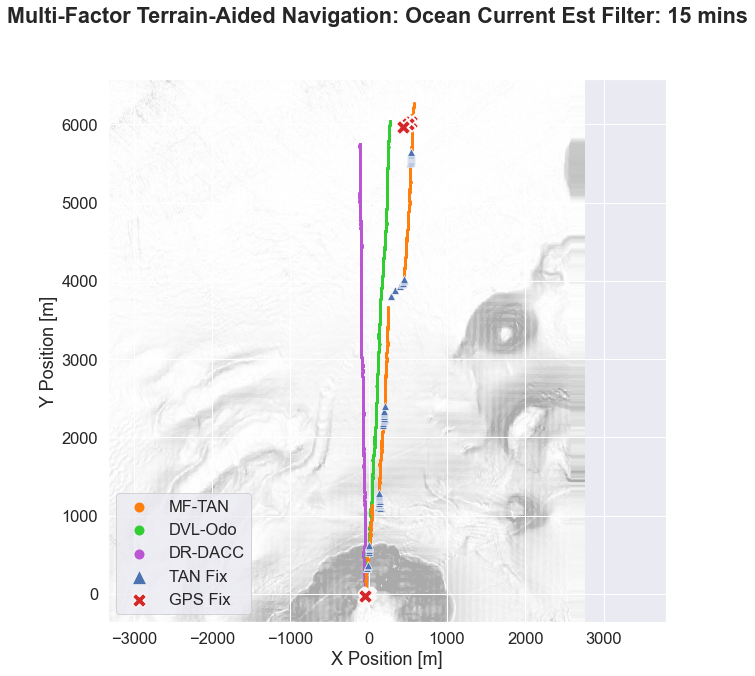

In [847]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale = 1.5)
linewidth = 8
plt_bg = True
# plt_bg = False


sns.scatterplot(
    tan_pos_x, 
    tan_pos_y, 
    linewidth=0, 
    color='tab:orange', 
    label='MF-TAN',
    s=linewidth, 
    zorder=4,
)
odos=3

# sns.scatterplot(
#     sf_tan_pos_x, 
#     sf_tan_pos_y, 
#     linewidth=5, 
#     color='red', 
#     label='SF-TAN',
#     s=linewidth, 
#     zorder=3,
# )
# odos=4

sns.scatterplot(
    ts.df.rel_pos_x, 
    ts.df.rel_pos_y, 
    linewidth=0, 
    color='limegreen', 
    label='DVL-Odo',
    s=linewidth, 
    zorder=2,
)

sns.scatterplot(
    x=df_dbd.m_x_lmc - dbd_origin_x_lmc,
    y=df_dbd.m_y_lmc - dbd_origin_y_lmc,
    color='mediumorchid',
    label='DR-DACC',
    linewidth=0,
    s=linewidth,
    data=df_dbd,
    zorder=1,
)


sns.scatterplot(
    tan_update_x, 
    tan_update_y, 
    zorder=4, 
    marker='^', 
    label='TAN Fix',
    s=60,
)

sns.scatterplot(
    x=df_dbd.m_gps_x_lmc - dbd_origin_x_lmc, 
    y=df_dbd.m_gps_y_lmc - dbd_origin_y_lmc,
    marker='X',
    color='tab:red', 
    s=200,
    label='GPS Fix',
    data=df_dbd,
    zorder=5,
)

lgnd = plt.legend(loc='lower left')
for i in range(odos):
    lgnd.legendHandles[i]._sizes = [100]
lgnd.legendHandles[odos]._sizes = [200]

plt.axis('equal')
xlim=ax.get_xlim()
ylim=ax.get_ylim()

MFTAN_bg = np.array(bathy_df.slope_list)
bg_threshold = 30
MFTAN_bg[MFTAN_bg>bg_threshold] = bg_threshold
MFTAN_bg[0] = 3*np.nanmax(MFTAN_bg)

if plt_bg:
    sns.scatterplot(
        bathy_df.utm_x_list - dbd_utm_x,
        bathy_df.utm_y_list - dbd_utm_y,
        MFTAN_bg,
        marker='s',
        ax=ax,
        s=200,
#         s=80,
#         s=20,
        palette="gray_r",
        linewidth=0,
        zorder=0,
        legend=False,
    )
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
plt.suptitle('Multi-Factor Terrain-Aided Navigation: Ocean Current Est Filter: %d mins' %ocean_current_time_filter, fontweight='bold')
#plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
#plt.close()
print('> Done plotting!')
plt.show()

---
<a id='navigation-performance'></a>
### B. Navigation Performance

DAC_x:  [-45.2273, -112.333, 542.6, 542.6, 500.339, 500.339]
DAC_y:  [-23.848, 5752.65, 6034.07, 6034.07, 6005.56, 6005.56]
GPS_x:  [-45.2273, 549.703, 542.6, 508.715, 500.339, 446.745]
GPS_y:  [-23.848, 6038.14, 6034.07, 6011.0, 6005.56, 5965.34]


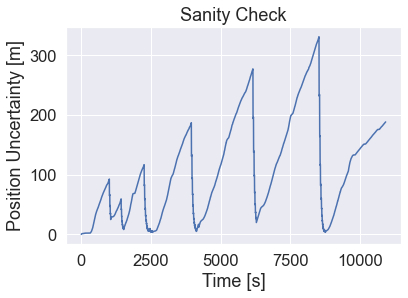

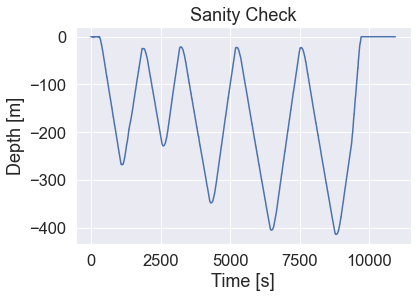

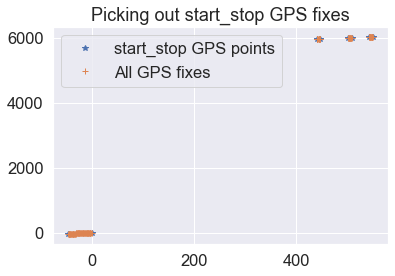

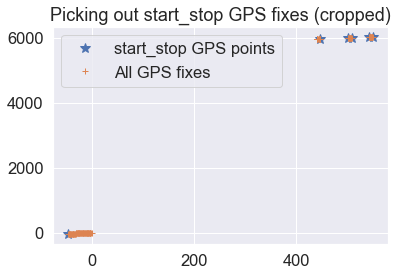

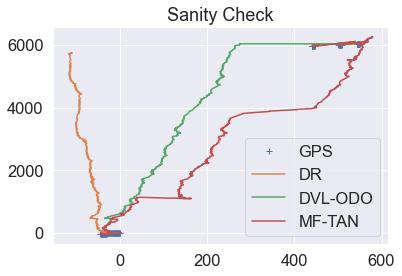

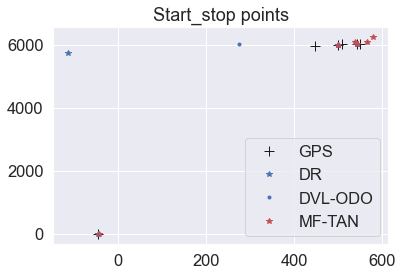

In [848]:
# Quantify Performance of DR-DACC, DVL-ODO, and MF-TAN

#%% Sanity Checks
time_plot = ts.df.time - ts.df.time[0]
plt.figure()
plt.plot(time_plot, tan_pos_r)
plt.xlabel('Time [s]')
plt.ylabel('Position Uncertainty [m]')
plt.title('Sanity Check')

plt.figure()
plt.plot(time_plot, -1*ts.df.depth)
plt.xlabel('Time [s]')
plt.ylabel('Depth [m]')
plt.title('Sanity Check')


#%% Extract last gps fix before start of dive and first gps fix when surfacing from a dive
surface_flag = False
depth_cutoff = 5
DBD_start_stop_points_idx = []
for i in range(1, len(df_dbd.m_depth) - 2):
    if not np.isnan(df_dbd.m_gps_x_lmc[i]) and surface_flag is False:
        surface_flag = True
        DBD_start_stop_points_idx.append(i)
    elif not np.isnan(df_dbd.m_gps_x_lmc[i]) and np.isnan(df_dbd.m_gps_x_lmc[i+1]) and np.isnan(df_dbd.m_gps_x_lmc[i+2]) and surface_flag is True:
            DBD_start_stop_points_idx.append(i)
            surface_flag = False
        
# print(DBD_start_stop_points_idx)
plt.figure()
plt.plot(df_dbd.m_gps_x_lmc[DBD_start_stop_points_idx] - dbd_origin_x_lmc,df_dbd.m_gps_y_lmc[DBD_start_stop_points_idx] - dbd_origin_y_lmc, '*')
plt.plot(df_dbd.m_gps_x_lmc - dbd_origin_x_lmc, df_dbd.m_gps_y_lmc - dbd_origin_y_lmc, '+')
plt.legend(['start_stop GPS points', 'All GPS fixes'])
plt.title('Picking out start_stop GPS fixes')

DBD_start_stop_points_idx_cut = DBD_start_stop_points_idx[1:-1]
plt.figure()
plt.plot(df_dbd.m_gps_x_lmc[DBD_start_stop_points_idx_cut] - dbd_origin_x_lmc,df_dbd.m_gps_y_lmc[DBD_start_stop_points_idx_cut] - dbd_origin_y_lmc, '*', markersize=10)
plt.plot(df_dbd.m_gps_x_lmc - dbd_origin_x_lmc, df_dbd.m_gps_y_lmc - dbd_origin_y_lmc, '+')
plt.legend(['start_stop GPS points', 'All GPS fixes'])
plt.title('Picking out start_stop GPS fixes (cropped)')

#%% Reconcile Glider Log timestamp to DVL timestamp and extract DVL-ODO and MF-TAN Nav start_stop points
DVL_start_stop_times = []
for idx in DBD_start_stop_points_idx_cut:
    DVL_start_stop_times.append(datetime.datetime.fromtimestamp(df_dbd.time[idx])) 
# print(DVL_start_stop_times)

DBD_start_stop_points_idx_cut = DBD_start_stop_points_idx[1:-1]
# print(DBD_start_stop_points_idx)
# print(DBD_start_stop_points_idx_cut)
nav = {
    'dive' : {
        'gps_x' : [],
        'gps_y' : [],
        
        'dac_x' : [],
        'dac_y' : [],
        
        'odo_x' : [],
        'odo_y' : [],
        
        'tan_x' : [],
        'tan_y' : [],
    }
}

origin_x = dbd_origin_x_lmc
origin_y = dbd_origin_y_lmc

for idx in DBD_start_stop_points_idx_cut:
    nav['dive']['gps_x'].append(df_dbd.m_gps_x_lmc[idx] - origin_x)
    nav['dive']['gps_y'].append(df_dbd.m_gps_y_lmc[idx] - origin_y)
dac_delay = 1
for i in range(0, len(DBD_start_stop_points_idx_cut)):
    if i %2 == 0:
        nav['dive']['dac_x'].append(df_dbd.m_x_lmc[DBD_start_stop_points_idx_cut[i]] - origin_x)
        nav['dive']['dac_y'].append(df_dbd.m_y_lmc[DBD_start_stop_points_idx_cut[i]] - origin_y)
    else:
        if not np.isnan(df_dbd.m_x_lmc[DBD_start_stop_points_idx_cut[i]-dac_delay] - origin_x):
            dac_x_temp = df_dbd.m_x_lmc[DBD_start_stop_points_idx_cut[i]-dac_delay] - origin_x
            dac_y_temp = df_dbd.m_y_lmc[DBD_start_stop_points_idx_cut[i]-dac_delay] - origin_y
        else:
            for j in range(DBD_start_stop_points_idx_cut[i]-dac_delay, 0, -1):
                if not np.isnan(df_dbd.m_x_lmc[j] - origin_x):
                    dac_x_temp = df_dbd.m_x_lmc[j] - origin_x
                    dac_y_temp = df_dbd.m_y_lmc[j] - origin_y
                    break
        nav['dive']['dac_x'].append(dac_x_temp)
        nav['dive']['dac_y'].append(dac_y_temp)
    
DVL_start = 0
DVL_end = -10
for i in range(1, len(DVL_start_stop_times),2):
    ts_temp = (ts.df[str(DVL_start_stop_times[i-1]):str(DVL_start_stop_times[i])].copy())
    nav['dive']['odo_x'].append(ts_temp.rel_pos_x[DVL_start])
    nav['dive']['odo_y'].append(ts_temp.rel_pos_y[DVL_start])
    nav['dive']['odo_x'].append(ts_temp.rel_pos_x[DVL_end])
    nav['dive']['odo_y'].append(ts_temp.rel_pos_y[DVL_end])
    nav['dive']['tan_x'].append(ts_temp.tan_pos_x[DVL_start])
    nav['dive']['tan_y'].append(ts_temp.tan_pos_y[DVL_start])
    nav['dive']['tan_x'].append(ts_temp.tan_pos_x[DVL_end])
    nav['dive']['tan_y'].append(ts_temp.tan_pos_y[DVL_end])
    
plt.figure()
plt.plot(df_dbd.m_gps_x_lmc - dbd_origin_x_lmc, df_dbd.m_gps_y_lmc - dbd_origin_y_lmc, '+')
plt.plot(df_dbd.m_x_lmc - dbd_origin_x_lmc, df_dbd.m_y_lmc - dbd_origin_y_lmc)
plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y)
plt.plot(ts.df.tan_pos_x, ts.df.tan_pos_y)
plt.legend(['GPS', "DR", "DVL-ODO", "MF-TAN"])
plt.title('Sanity Check')

plt.figure()
plt.plot(nav['dive']['gps_x'], nav['dive']['gps_y'], 'k+' , markersize=10)
plt.plot(nav['dive']['dac_x'], nav['dive']['dac_y'], 'b*', markersize=6 )
plt.plot(nav['dive']['odo_x'], nav['dive']['odo_y'], 'o', markersize=3 )
plt.plot(nav['dive']['tan_x'], nav['dive']['tan_y'], 'r*', markersize=6 )

plt.legend(['GPS', 'DR', "DVL-ODO", "MF-TAN"])
plt.title('Start_stop points')


print('DAC_x: ', nav['dive']['dac_x'])
print('DAC_y: ', nav['dive']['dac_y'])
print('GPS_x: ', nav['dive']['gps_x'])
print('GPS_y: ', nav['dive']['gps_y'])
# print('DVL_odo_x: ', nav['dive']['odo_x'])
# print('DVL_odo_y: ', nav['dive']['odo_y'])

---
<a id='print_metrics'></a>
### Print Performance Metrics

In [850]:
nav_range = [] 
dac_error = []
odo_error = []
tan_error = []

## Needed for only dive A --> to fix, would need to automate counting how many actual dives "legs" there are
for leg in range(1,2): 
# for leg in range(1, len(nav['dive']['gps_x']),2):
    delta_gps_x = nav['dive']['gps_x'][leg] - nav['dive']['gps_x'][leg-1]
    delta_gps_y = nav['dive']['gps_y'][leg] - nav['dive']['gps_y'][leg-1]
    delta_gps   = np.linalg.norm([delta_gps_x, delta_gps_y])
    nav_range.append(delta_gps)

    delta_dac_x = nav['dive']['dac_x'][leg] - nav['dive']['gps_x'][leg]
    delta_dac_y = nav['dive']['dac_y'][leg] - nav['dive']['gps_y'][leg]
    delta_dac   = np.linalg.norm([delta_dac_x, delta_dac_y])
    dac_error.append(delta_dac)

    delta_odo_x = nav['dive']['odo_x'][leg] - nav['dive']['gps_x'][leg]
    delta_odo_y = nav['dive']['odo_y'][leg] - nav['dive']['gps_y'][leg]
    delta_odo   = np.linalg.norm([delta_odo_x, delta_odo_y])
    odo_error.append(delta_odo)

    delta_tan_x = nav['dive']['tan_x'][leg] - nav['dive']['gps_x'][leg]
    delta_tan_y = nav['dive']['tan_y'][leg] - nav['dive']['gps_y'][leg]
    delta_tan   = np.linalg.norm([delta_tan_x, delta_tan_y])
    tan_error.append(delta_tan)

mission_range = sum(nav_range)
print('Dive: ', ts_label)
print('  Range:   %3d'   % mission_range)
print('  DR-DACC: %0.1f' % (sum(dac_error)/sum(nav_range)*100))
print('  DVL-Odo: %0.1f' % (sum(odo_error)/sum(nav_range)*100))
print('  MF-TAN:  %0.1f' % (sum(tan_error)/sum(nav_range)*100))


Dive:  A
  Range:   6091
  DR-DACC: 11.8
  DVL-Odo: 4.5
  MF-TAN:  3.6


---
<a id='sandbox'></a>
# Sandbox
Code below this cell is experimental and may contain bugs and/or may be garbage code

---

(364273.2368421946, 364872.06290104124, 4043807.001982219, 4049759.2675382276)

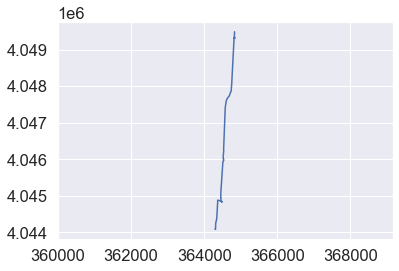

In [767]:
#Sanity Check for UTM estimate used to compare to map
plt.figure()
plt.plot(utm_est_x_list, utm_est_y_list)
plt.axis('equal')


Text(0.5, 1.0, 'Orientation TAU')

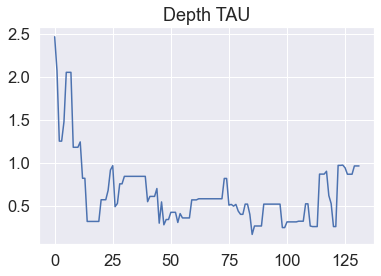

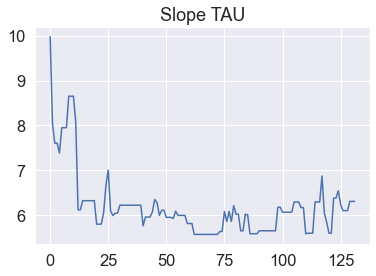

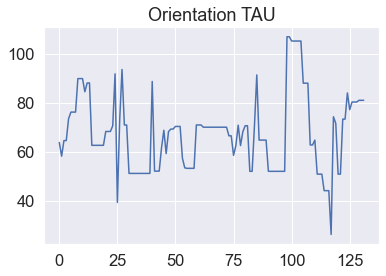

In [793]:
plt.figure()
plt.plot(depth_var_list)
plt.title('Depth TAU')

plt.figure()
plt.plot(slope_var_list)
plt.title('Slope TAU')

plt.figure()
plt.plot(orient_var_list)
plt.title('Orientation TAU')


Text(0.5, 1.0, 'orient')

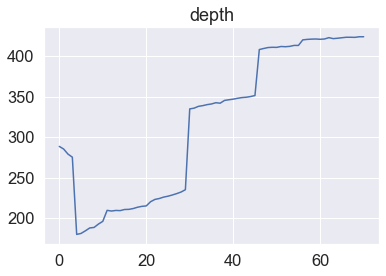

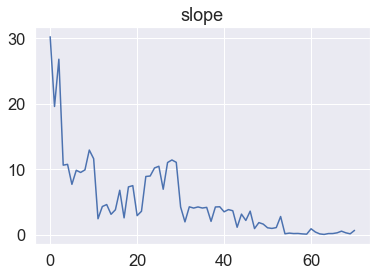

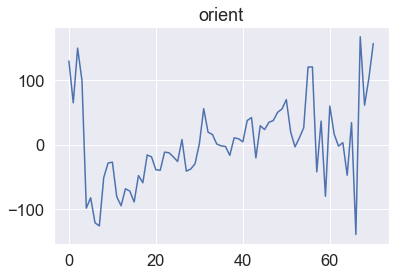

In [745]:
# Plots of Factors used for fixes
plt.figure()
plt.plot(tan_update_depth)
plt.title('depth')

plt.figure()
plt.plot(tan_update_slope)
plt.title('slope')

plt.figure()
plt.plot(tan_update_orient)
plt.title('orient')


### Variability of Water Column Velocity Estimates as Measured by the DVL

Hypothesis: we expect to see higher variability during inflections.

Therefore, when implementing the UKF, we can account for this by increasing our uncertainty of the DVL water column velocity estimates when vehicle is pitched a certain amount

In [139]:
timeseries_nodes = {}

# for t in range(1,len(ts.df)):
for t in range(1,len(ts.df)):
    time    = ts.df.time[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.depth[t]

    # retrieve ocean current estimate from water column 
    # voc_u = voc_u_list[int(depth)]
    # voc_v = voc_v_list[int(depth)]
    good_node_list = []
    count = 0
    cum_voc_u = 0
    cum_voc_v = 0
    # Extract all shear nodes at current depth
    wc_depth = water_column.get_wc_bin(depth)
    node_list = water_column.get_voc_at_depth(wc_depth)

    # Iterate through shear nodes at depth
    for shear_node in node_list:
        tt  = shear_node.t
        voc = shear_node.voc
        if not(voc.is_none()):
            # filter out large values when computing averages
            if voc.mag < voc_mag_filter:
                timeseries_nodes[tt] = voc
#                 good_node_list.append(shear_node)
                
#     ## TODO possibly --> Median filter of nodes at given depth         
#     if (len(good_node_list) > 0):
#         for i in range(len(good_node_list)):
#             if i == 0:
#                 count += 1
#                 cum_voc_u += good_node_list[0].voc.u
#                 cum_voc_v += good_node_list[0].voc.v
#             else: 
#                 time_between_current_estimates = good_node_list[i].t - good_node_list[0].t
#                 if time_between_current_estimates > (ocean_current_time_filter*60):
#                     count += 1 
#                     cum_voc_u += good_node_list[i].voc.u
#                     cum_voc_v += good_node_list[i].voc.v
#         #voc_avg = OceanCurrent(cum_voc_u/count, cum_voc_v/count, 0)
#         voc_u = cum_voc_u/count
#         voc_v = cum_voc_v/count
#         u_list.append(voc_u)
#         v_list.append(voc_v)

#     else:
#         voc_u = np.nan
#         voc_v = np.nan
#         u_list.append(voc_u)
#         v_list.append(voc_v)    
    


In [140]:
timeseries_nodes_sorted = {key:value for key, value in sorted(timeseries_nodes.items(), key=lambda item: int(item[0]))}
# print(timeseries_nodes_sorted)
ts_sorted = pd.DataFrame.from_dict(timeseries_nodes_sorted)
# plt.figure()
# plt.xlabel('Time [s]')
# plt.ylabel('Avg Ocean Current Vel [m/s]')

# period = 10
# for key in timeseries_nodes_sorted:
#     sum_cum = 0
#     for i in range(1,10):
#         sum_cum  = sum_cum + ((timeseries_nodes_sorted[key].u + timeseries_nodes_sorted[key].v)/2)
#         if i == 10:
#             plt.plot(sum_cum/period, '*k')


ValueError: If using all scalar values, you must pass an index

In [ ]:
#############################################
# # GET DVL-ODO AND MF-TAN ###################
# time_zone_offset = 5
# last_time_before_gps = 1574397962 + time_zone_offset*60*60
# for t in range(len(ts.df)):
#     if abs(ts.df.time[t] - last_time_before_gps) < 30:
#         print('%d,  %0.1f,  %0.1f,  %0.1f,  %0.1f' % (ts.df.time[t],  ts.df.rel_pos_x[t],  ts.df.rel_pos_y[t], tan_pos_x[t], tan_pos_y[t]))
# #############################################
# # GET DR-DACC ##############################
# start_t = datetime.datetime.fromtimestamp(ts.df.time[0])
# end_t   = datetime.datetime.fromtimestamp(ts.df.time[-1])
# dur     = end_t - start_t 
# df_dbd  = ts_flight_kolumbo_all.df[str(start_t):str(end_t)].copy()

# # extract start_t position "origin" from the glider flight data 
# for t in range(len(df_dbd)):
#     if not np.isnan(df_dbd.m_x_lmc[t]):
#         dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
#         dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
#         dbd_origin_m_lat = df_dbd.m_lat[t]
#         dbd_origin_m_lon = df_dbd.m_lon[t]
#         break

# dbd_utm_x, dbd_utm_y, zone, zone_letter = get_utm_coords_from_glider_lat_lon(
#     dbd_origin_m_lat, 
#     dbd_origin_m_lon
# )

# for t in range(len(df_dbd)):
#     print('%d,  %0.1f,  %0.1f  %0.1f,  %0.1f' % (df_dbd.m_present_time[t], df_dbd.m_gps_x_lmc[t]-dbd_origin_x_lmc, df_dbd.m_gps_y_lmc[t]-dbd_origin_y_lmc, df_dbd.m_x_lmc[t]-dbd_origin_x_lmc, df_dbd.m_y_lmc[t]-dbd_origin_y_lmc))

In [ ]:

depth_cutoff_init = 5
depth_cutoff = 30# meters
time_between_DVL_dives = 120 #seconds

init_flag = True
for i in range(0,len(ts.df.time)):
    if init_flag == True:
        if ts.df.depth[i] > depth_cutoff_init:
            gps_start_index = i
            init_flag  = False
            continue

print(gps_start_index)

In [106]:
depth_cutoff = 3# meters
time_between_DVL_dives = 120 #seconds



for i in range(0, len(df_dbd.m_depth), 1):
    if df_dbd.m_depth[i] > depth_cutoff:
        start_gps_index = i
        break
for j in range(start_gps_index+10, len(df_dbd.m_depth), 1):
    if not np.isnan(df_dbd.m_gps_x_lmc[j]):
        stop_gps_index = j
        break
stop_gps_index = -(len(df_dbd.m_gps_x_lmc) - stop_gps_index)
print(start_gps_index)
print(stop_gps_index)
df_dbd.m_gps_x_lmc[2290]

71
-259


549.703

In [107]:
# print(df_dbd.m_gps_x_lmc[72:78])
# print(df_dbd.m_gps_y_lmc[72:78])

# print(df_dbd.m_gps_x_lmc[-63:-60])
# print(df_dbd.m_gps_y_lmc[-63:-60])
# gps_start_index = 72
# gps_end_index = -62
gps_start_index = start_gps_index
gps_end_index = stop_gps_index

origin_x_lmc = df_dbd.m_gps_x_lmc[gps_start_index]
origin_y_lmc = df_dbd.m_gps_y_lmc[gps_start_index]
start_gps = datetime.datetime.fromtimestamp(df_dbd.time[gps_start_index])
end_gps   = datetime.datetime.fromtimestamp(df_dbd.time[gps_end_index])

print(start_gps)
print(end_gps)
ts_new = ts.df[str(start_gps):str(end_gps)].copy()
ts_new = ts_new[0:(-1 -5)] # to account for lag
print(ts_new.rel_pos_x[1] - origin_x_lmc)

print(origin_x_lmc)
print(origin_y_lmc)

2019-11-26 12:27:37.293820
2019-11-26 15:05:03.956760
1.1106184840427176
-44.8559
-28.0875


In [108]:
# 'gps_x' : [df_dbd.m_gps_x_lmc[gps_start_index] - origin_x_lmc, df_dbd.m_gps_x_lmc[gps_end_index] - origin_x_lmc],
# 'gps_y' : [df_dbd.m_gps_y_lmc[gps_start_index] - origin_y_lmc, df_dbd.m_gps_y_lmc[gps_end_index] - origin_y_lmc],
print('GPS')
print(df_dbd.m_gps_x_lmc[gps_start_index] - origin_x_lmc)
print(df_dbd.m_gps_x_lmc[gps_end_index] - origin_x_lmc)
        
print(df_dbd.m_gps_y_lmc[gps_start_index] - origin_y_lmc)
print(df_dbd.m_gps_y_lmc[gps_end_index] - origin_y_lmc)

print('DR-DACC')
print(df_dbd.m_x_lmc[gps_start_index] - origin_x_lmc)
print(df_dbd.m_x_lmc[gps_end_index] - origin_x_lmc)
        
print(df_dbd.m_y_lmc[gps_start_index] - origin_y_lmc)
print(df_dbd.m_y_lmc[gps_end_index] - origin_y_lmc)



GPS
0.0
594.5589
0.0
6066.2275
DR-DACC
0.0
594.5589
0.0
6066.2275


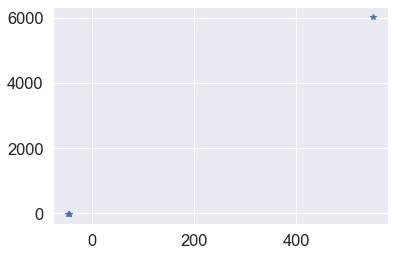

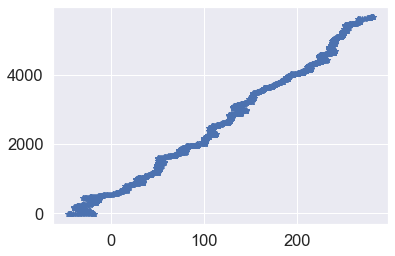

In [78]:
plt.figure()
plt.plot(df_dbd.m_gps_x_lmc[gps_start_index-1:gps_end_index+1], df_dbd.m_gps_y_lmc[gps_start_index-1:gps_end_index+1], '*')

plt.figure()
plt.plot(ts_new.rel_pos_x, ts_new.rel_pos_y, '*')

In [111]:
nav = {
    'A' : {
        'gps_x' : [df_dbd.m_gps_x_lmc[gps_start_index] - origin_x_lmc, df_dbd.m_gps_x_lmc[gps_end_index] - origin_x_lmc],
        'gps_y' : [df_dbd.m_gps_y_lmc[gps_start_index] - origin_y_lmc, df_dbd.m_gps_y_lmc[gps_end_index] - origin_y_lmc],
        
        'dac_x' : [df_dbd.m_x_lmc[gps_start_index] - origin_x_lmc, df_dbd.m_x_lmc[gps_end_index] - origin_x_lmc],
        'dac_y' : [df_dbd.m_y_lmc[gps_start_index] - origin_y_lmc, df_dbd.m_y_lmc[gps_end_index] - origin_y_lmc],
        
        'odo_x' : [ts_new.rel_pos_x[0] - origin_x_lmc, ts_new.rel_pos_x[-1] - origin_x_lmc],
        'odo_y' : [ts_new.rel_pos_y[0] - origin_y_lmc, ts_new.rel_pos_y[-1] - origin_y_lmc],
        
        'tan_x' : [ts_new.tan_pos_x[0] - origin_x_lmc, ts_new.tan_pos_x[-1] - origin_y_lmc],
        'tan_y' : [ts_new.tan_pos_y[0] - origin_y_lmc, ts_new.tan_pos_y[-1] - origin_y_lmc],
        
#         'odo_x' : [ts_new.rel_pos_x[1] - origin_x_lmc, ts_new.rel_pos_x[-3] - origin_x_lmc],
#         'odo_y' : [ts_new.rel_pos_y[1] - origin_y_lmc, ts_new.rel_pos_y[-3] - origin_y_lmc],
        
#         'tan_x' : [ts_new.tan_pos_x[1] - origin_x_lmc, ts_new.tan_pos_x[-3] - origin_y_lmc],
#         'tan_y' : [ts_new.tan_pos_y[1] - origin_y_lmc, ts_new.tan_pos_y[-3] - origin_y_lmc],
        
        
     },
     
#     'E' : {
#         'm_time': [1574384188, 1574384826, 1574385280, 1574385880],
        
#         'gps_x' : [0, 161.1, 261.9, 299.7, 413.6],
#         'gps_y' : [0, 229.3, 396.4, 436.6, 463.1],
        
#         'dac_x' : [0,  -5.6, 189.0, 243.4, 273.9],
#         'dac_y' : [0,  73.5, 308.2, 367.3, 435.6],
        
#         'odo_x' : [0,  90.1, 253.1, 301.2, 337.4],
#         'odo_y' : [0, 128.7, 348.1, 396.3, 459.0],
        
#         'tan_x' : [0,  94.8, 218.0, 312.8, 321.3],
#         'tan_y' : [0, 229.2, 391.7, 420.1, 464.6],
#     },

    
#     'F' : {
#         'm_time': [1574388280, 1574388913, 1574389511, 1574390289],
        
#         'gps_x' : [0,  -42.3,  -99.7, -197.3, -420.3],
#         'gps_y' : [0,  211.8,  299.6,  488.7,  652.6],
        
#         'dac_x' : [0, -201.4, -145.9, -300.4, -521.5],
#         'dac_y' : [0,  157.7,  279.3,  418.6,  500.9],
        
#         'odo_x' : [0, -148.7, -123.9, -260.7, -476.6],
#         'odo_y' : [0,  201.3,  290.0,  447.5,  547.9],
        
#         'tan_x' : [0, -129.5, -114.3, -210.0, -402.8],
#         'tan_y' : [0,  235.2,  306.6,  462.7,  620.1],
#     },
    
    
#     'G' : {
#         'm_time': [1574396554, 1574397216, 1574397962],
#         'gps_x' : [0, 122.7, 273.6, 345.7],
#         'gps_y' : [0, 144.0, 198.4, 198.4],
        
#         'dac_x' : [0, 198.3, 314.6, 360.4],
#         'dac_y' : [0, 106.8, 198.4, 198.4],
        
#         'odo_x' : [0, 150.3, 280.8, 307.3],
#         'odo_y' : [0, 101.6, 158.6, 173.9],
        
#         'tan_x' : [0, 153.5, 272.3, 337.4],
#         'tan_y' : [0, 130.0, 184.3, 197.0],
#     }
}

for dive in nav:
    print(dive)
    nav_range = [] 
    dac_error = []
    odo_error = []
    tan_error = []
    for leg in range(1, len(nav[dive]['gps_x'])):
        delta_gps_x = nav[dive]['gps_x'][leg] - nav[dive]['gps_x'][leg-1]
        delta_gps_y = nav[dive]['gps_y'][leg] - nav[dive]['gps_y'][leg-1]
        delta_gps   = np.linalg.norm([delta_gps_x, delta_gps_y])
        nav_range.append(delta_gps)
        
        delta_dac_x = nav[dive]['dac_x'][leg] - nav[dive]['gps_x'][leg]
        delta_dac_y = nav[dive]['dac_y'][leg] - nav[dive]['gps_y'][leg]
        delta_dac   = np.linalg.norm([delta_dac_x, delta_dac_y])
        dac_error.append(delta_dac)
        
        delta_odo_x = nav[dive]['odo_x'][leg] - nav[dive]['gps_x'][leg]
        delta_odo_y = nav[dive]['odo_y'][leg] - nav[dive]['gps_y'][leg]
        delta_odo   = np.linalg.norm([delta_odo_x, delta_odo_y])
        odo_error.append(delta_odo)

        delta_tan_x = nav[dive]['tan_x'][leg] - nav[dive]['gps_x'][leg]
        delta_tan_y = nav[dive]['tan_y'][leg] - nav[dive]['gps_y'][leg]
        delta_tan   = np.linalg.norm([delta_tan_x, delta_tan_y])
        tan_error.append(delta_tan)

    mission_range = sum(nav_range)
    print('  Range:   %3d'   % mission_range)
    print('  DR-DACC: %0.1f' % (sum(dac_error)/sum(nav_range)*100))
    print('  DVL-Odo: %0.1f' % (sum(odo_error)/sum(nav_range)*100))
    print('  MF-TAN:  %0.1f' % (sum(tan_error)/sum(nav_range)*100))
    print()

A
  Range:   6095
  DR-DACC: 0.0
  DVL-Odo: 7.5
  MF-TAN:  3.4



In [112]:
print(nav)

{'A': {'gps_x': [0.0, 594.5589], 'gps_y': [0.0, 6066.2275], 'dac_x': [0.0, 594.5589], 'dac_y': [0.0, 6066.2275], 'odo_x': [-0.3714000000000013, 325.6014032204048], 'odo_y': [4.2395, 5697.478718989161], 'tan_x': [-0.3714000000000013, 448.3498909202043], 'tan_y': [4.2395, 5923.273792342108]}}
